In [76]:
import numpy as np
import numpy.random as random
import random as r
from collections import OrderedDict
import pandas as pd
from statistics import mean 
import matplotlib.cm as cm
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

In [2]:
stops = ["Służew", "Wierzbno", "Pole Mokotowskie", "Dworzec", "Rondo ONZ", 
           "Dworzec_2", "Pole Mokotowskie_2", "Wierzbno_2", "Służew_2"]

In [50]:
def f(cena=0):
    if cena <= 4:
        wspolczynnik = round(-(0.33*cena)**2.4+2,3)
    else: 
        wspolczynnik = 0
    return wspolczynnik

In [52]:
def simulate_passengers(cena):
    passengers = {}
    for hour in range(24):
        passengers[hour] = {}
    for stop in stops:
        if stop != "Służew_2":
            wsp_ceny=f(cena)
            if stop == "Dworzec":
                number_passengers_in = random.gamma(6, 2, size=int(2000*wsp_ceny)).round(0)
                number_passengers_in = number_passengers_in[(number_passengers_in >=0) & \
                                                            (number_passengers_in <=23)]
                number_passengers_out = random.gamma(6, 2, size=int(2000*wsp_ceny)).round(0)
                number_passengers_out = number_passengers_out[(number_passengers_out >=0) & \
                                                              (number_passengers_out <=23)]
            elif '2' in stop:
                number_passengers_in = random.gamma(9, 1, size=int(400*wsp_ceny)).round(0).clip(0, 23)
                number_passengers_in = np.array([24-value for value in number_passengers_in])
                number_passengers_out = random.gamma(9, 1, size=int(1000*wsp_ceny)).round(0).clip(0, 23)
                number_passengers_out = np.array([24-value for value in number_passengers_out])
            elif stop == "Rondo ONZ": 
                number_passengers_in = random.gamma(8, 1, size=int(3000*wsp_ceny)).round(0).clip(0, 23)
                number_passengers_in = np.array([24-value for value in number_passengers_in])
            else: 
                number_passengers_in = random.gamma(9, 1, size=int(1000*wsp_ceny)).round(0).clip(0, 23)
                number_passengers_out = random.gamma(9, 1, size=int(400*wsp_ceny)).round(0).clip(0, 23)
            for hour in range(24):
                passengers[hour][stop] = {}
                passengers[hour][stop]["in"] = len(number_passengers_in[number_passengers_in == hour])
                if stop not in ["Służew", "Służew_2", "Rondo ONZ"]:
                    passengers[hour][stop]["out"] = len(number_passengers_out\
                                                              [number_passengers_out == hour])
    return passengers

In [53]:
def random_times(n, num_terms = None):
    output = []
    mean = n/num_terms
    for time in range(num_terms):
        if time+1 == num_terms:
            output.append(n - sum(output))
        else:
            output.append(round(random.normal(mean, mean*0.1), 0))
    return output

In [54]:
def model(hour, stats, buses, capacity):
    # filtruje słownik z liczbą pasażerów (na daną godzine)
    stats_hour = stats[hour]
    # inicjuję potrzebne słowniki
    stats_stops = {}
    bus_passengers = {}
    for bus in range(buses):
        bus_passengers[bus+1] = {}
        bus_passengers[bus+1]['in'] = []
        bus_passengers[bus+1]['out'] = []
    # tworzę tuplę z listami wsiadających oraz wysiadających pasażerów z danego busa
    # długość list = liczba busów
    for key, value in stats_hour.items():
        if 'out' in value:
            stats_stops[key] = (random_times(value['in'], buses), random_times(value['out'], buses))
        else:
            stats_stops[key] = (random_times(value['in'], buses),)
    # inicjuję finalną listę z przewiezionymi pasażerami przez konkretne busy
    bus_output = []
    for bus in range(buses):
        # liczba aktualnych pasażerów w busie
        passengers = 0
        # liczba w sumie przewiezionych pasażerów
        passengers_final = 0
        for key, value in stats_stops.items():
            bus_passengers[bus+1]['in'].append(value[0][bus])
            if len(value) > 1:
                bus_passengers[bus+1]['out'].append(value[1][bus])
            else:
                bus_passengers[bus+1]['out'].append(0)
        for i in range(len(bus_passengers[bus+1]['in'])):
            # i == 4 to rondo onz
            if i == 4:
                passengers = 0
            else:
                passengers -= min(bus_passengers[bus+1]['out'][i], passengers)
            passengers_final += min(capacity-passengers, bus_passengers[bus+1]['in'][i])
            passengers += min(capacity-passengers, bus_passengers[bus+1]['in'][i])
        bus_output.append(passengers_final)
    return bus_output

In [83]:
def symulacja_init(iteration, cena_biletu, koszt_autobusu, list_buses, capacity):
    profits = []
    for i in range(iteration):
        profit = 0
        stats = simulate_passengers()
        for hour in range(24):
            passengers = model(hour, stats, list_buses[hour], capacity)
            profit += sum([value*cena_biletu for value in passengers])
            profit -= koszt_autobusu*list_buses[hour]
        profits.append(profit)
    return profits

In [106]:
def symulacja(iteration, cena_biletu, koszt_autobusu, buses, capacity):
    profits = []
    optimum_buses = []
    for i in range(iteration):
        profit = 0
        hour_bus = []
        stats = simulate_passengers(cena_biletu)
        for hour in range(24):
            hour_profit = []
            for bus in range(1, buses+1):
                passengers = model(hour, stats, bus, capacity)
                profit += sum([value*cena_biletu for value in passengers])
                profit -= koszt_autobusu*bus
                hour_profit.append(profit)
            hour_bus.append(hour_profit.index(max(hour_profit))+1)
            profit = max(hour_profit)
        profits.append(profit)
        optimum_buses.append(hour_bus)
    return profits, optimum_buses

In [147]:
def symulacja(iteration, cena_biletu, koszt_autobusu, buses, capacity):
    profits = []
    optimum_buses = []

    for i in range(iteration):
        profit = 0
        hour_bus = []
        stats = simulate_passengers(cena_biletu)
        for hour in range(24):
            hour_profit = []
            for bus in range(1, buses+1):
          
                passengers = model(hour, stats, bus, capacity)
                profit += sum([value*cena_biletu for value in passengers])
                profit -= koszt_autobusu*bus
                hour_profit.append(profit)
                
            hour_bus.append(hour_profit.index(max(hour_profit))+1)
            profit = max(hour_profit)
        
        profits.append(profit)
        optimum_buses.append(hour_bus)
         
    return profits, optimum_buses

In [348]:

mean(symulacja(3,2,200,3,40)[0])

15538.0

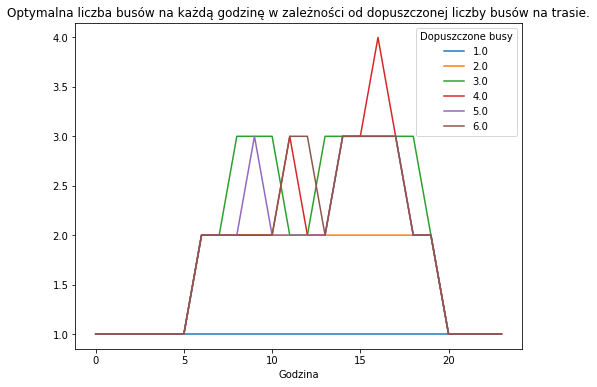

In [370]:
### Symulacja optymalnej liczby busów przy zadanej cenie biletu, koszcie i capacity
iteration=2
ceny =3.8
koszt_autobusu=200
buses=range(1,7,1)
capacity=40
data = pd.DataFrame()

for b in buses:
    for i in range(iteration):
        for h in range(24):
            data = data.append({"Dopuszczone busy": b, "Godzina":h,
                                "liczba busów": symulacja(iteration, ceny, koszt_autobusu, b, capacity)[1][i][h]}, ignore_index=True)
            
            


#pd.set_option('display.max_rows', data.shape[0]+1)
data.groupby(['Godzina','Dopuszczone busy'])['liczba busów'].median().round(0).unstack(1).plot.line(figsize=(8, 6),title="Optymalna liczba busów na każdą godzinę w zależności od dopuszczonej liczby busów na trasie.")

           

In [371]:
### Symulacja optymalnej liczby busów od ceny biletu, liczby busów i godziny
iteration=2
ceny =np.arange(0.0, 4.2,0.2)
koszt_autobusu=200
buses=range(1,7,1)
capacity=40
data1 = pd.DataFrame()

for p in ceny:
    for b in buses:
        for i in range(iteration):
            for h in range(24):
                data1 = data1.append({"Cena":p, "Dopuszczone busy": b, "Godzina":h,
                                    "liczba busów": symulacja(iteration, p, koszt_autobusu, b, capacity)[1][i][h]}, ignore_index=True)

#data1
#pd.set_option('display.max_rows', data1.shape[0]+1)
data1=data1.groupby(['Dopuszczone busy','Cena','Godzina'])['liczba busów'].median().round(0).reset_index()





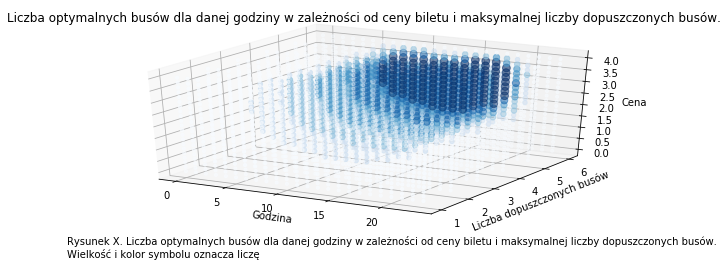

In [374]:
x_line=data1['Godzina']
y_line=data1['Dopuszczone busy']
z_line=data1['Cena']
l_b=data1['liczba busów']*10

fig = plt.figure(
    figsize=plt.figaspect(0.4)
)
ax = fig.add_subplot(1,1,1, projection='3d')
scat1=ax.scatter3D(x_line, y_line, z_line, 'gray', s=l_b,c=l_b, marker='o',cmap = cm.Blues)

ax.set_xlabel("Godzina")
ax.set_ylabel("Liczba dopuszczonych busów")
ax.set_zlabel("Cena")
ax.set_title("Liczba optymalnych busów dla danej godziny w zależności od ceny biletu i maksymalnej liczby dopuszczonych busów.",size=12)
fig.text(.1, -0.02, "Rysunek X. Liczba optymalnych busów dla danej godziny w zależności od ceny biletu i maksymalnej liczby dopuszczonych busów. \n"
                     "Wielkość i kolor symbolu oznacza liczę  \n", ha='left')
plt.show()

In [375]:
### Symulacja zysku od ceny i liczby busów
iteration=2
ceny =np.arange(0.0, 4.2,0.2).round(1)
koszt_autobusu=200
buses=range(1,7,1)
capacity=40
data2 = pd.DataFrame()

for p in ceny:
    for b in buses:
        data2 = data2.append({"Cena":p, "Dopuszczone busy": b, 
                            "Zysk": mean(symulacja(iteration, p, koszt_autobusu, b, capacity)[0])}, ignore_index=True)

#data
#pd.set_option('display.max_rows', data.shape[0]+1)
#data=data.groupby(['Dopuszczone busy','Cena','Godzina'])['liczba busów'].median().round(0).reset_index()


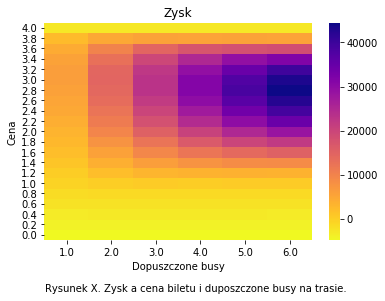

In [376]:
import seaborn as sns
test_pivoted=data2.pivot("Cena","Dopuszczone busy","Zysk")
ax=sns.heatmap(test_pivoted, cmap=cm.plasma_r)
ax.invert_yaxis()
ax.set_title('Zysk')
ax.text(0.01, -5, "Rysunek X. Zysk a cena biletu i duposzczone busy na trasie.", ha='left')
plt.show()